In [116]:
import pybaseball
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
plt.style.use('seaborn')
#Import statcast data
full = pybaseball.statcast(start_dt='2016-01-01', end_dt='2021-12-31')
print(f'Total pitches in selected timeframe: {full.shape[0]}')

This is a large query, it may take a moment to complete


  0%|                                                                                         | 0/1210 [00:00<?, ?it/s]

Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [09:52<00:00,  2.04it/s]


Total pitches in selected timeframe: 3562116


<AxesSubplot:xlabel='pitch_type', ylabel='release_spin_rate'>

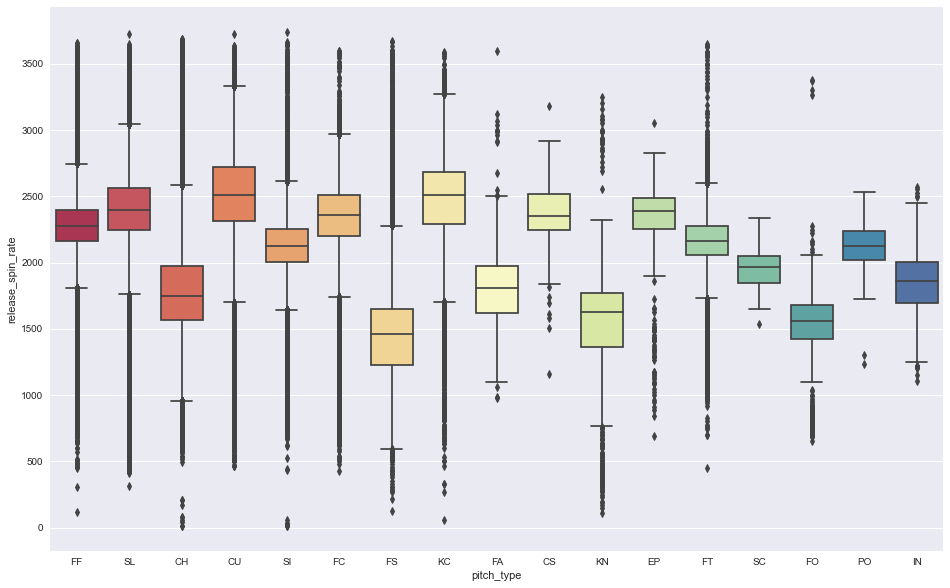

In [6]:
fig, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x='pitch_type', y='release_spin_rate', data=full, ax=ax, palette='Spectral')

In [149]:
def m_avg_by_year(df, avg_window, year_column = 'pitch_year',
                  group_col = 'game_date', agg_col = 'release_spin_rate',
                  agg_measure = 'mean'):
    """Group Data by Year and calculate moving average to prevent data skewing YoY"""
    grouped = df.groupby(year_column)
    frames = []
    for name, data in grouped:
        avg_data = data.groupby(group_col).agg({agg_col : agg_measure}).dropna()
        avg_data['moving'] = avg_data.release_spin_rate.rolling(window=avg_window).mean()
        avg_data['graph_date'] = avg_data.index.strftime('%m-%d')
        avg_data['pitch_year'] = name
        avg_data.reset_index(inplace=True)
        frames.append(avg_data)
    return pd.concat(frames, ignore_index=True)

def plot_yoy_rate(df, window, player=None, cmap='ocean_r',):
    """Plots spin rate Data YoY on a shared axis"""
    if player:
        df = df[(df.player_name == player)]
    g = m_avg_by_year(df, window)
    #Pivot for cleaner graphing, and exclude post-season dates
    graph_piv = pd.pivot_table(g[g.graph_date < '09-30'][['moving', 'pitch_year', 'graph_date']],
                        index=['graph_date'], columns=['pitch_year'], values=['moving'])
    #Populate NA values with last value - critical for individual players, fills All-Star Break for aggregate data
    graph_piv.fillna(method='ffill', inplace=True)
    graph_piv.loc[datetime.now().strftime('%m-%d'): , ('moving', 2021)] = np.nan
    
    #Return graph object
    ax = graph_piv.plot(colormap=cmap, figsize=(16,6))
    ax.legend(['2016', '2017', '2018', '2019', '2020', '2021'])
    ax.set_ylabel("Average Spin Rate")
    ax.set_xlabel("Date")
    return ax


Text(55, 2290, 'MLB signals crackdown\non foreign substances')

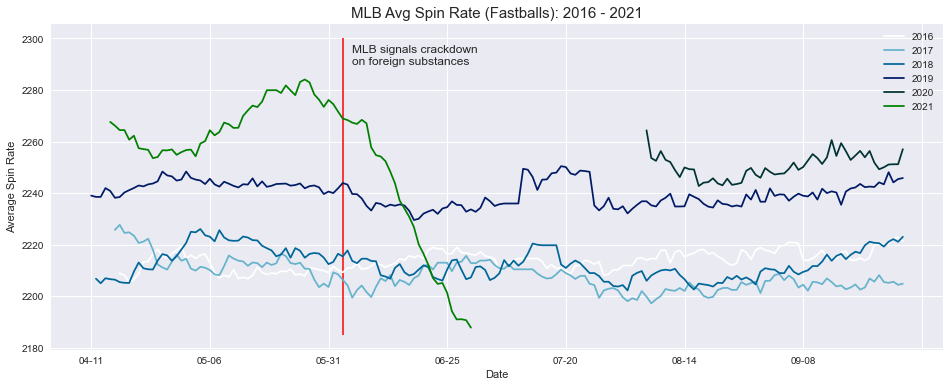

In [164]:
#Filter for Fastballs
fast_balls = full[full.pitch_type.isin(['FC', 'FT', 'SI', 'FF', 'FS'])].copy()
fast_balls['pitch_year'] = [date.year for date in fast_balls.game_date]

#Plot 15 day moving average of Spin rate 
ax = plot_yoy_rate(fast_balls, 15)
ax.set_title('MLB Avg Spin Rate (Fastballs): 2016 - 2021', fontsize=15)
ax.vlines(x=[53], ymin=2185, ymax=2300, colors='red', linestyles='solid', linewidth=1.5)
ax.text(55, 2290, 'MLB signals crackdown\non foreign substances', fontsize=12)

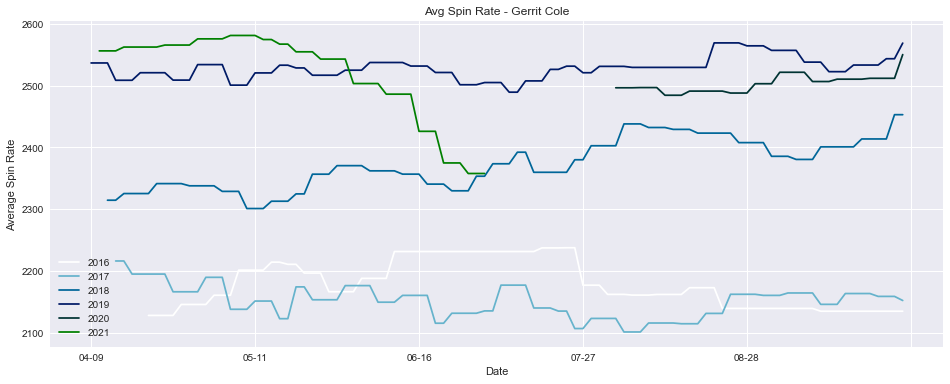

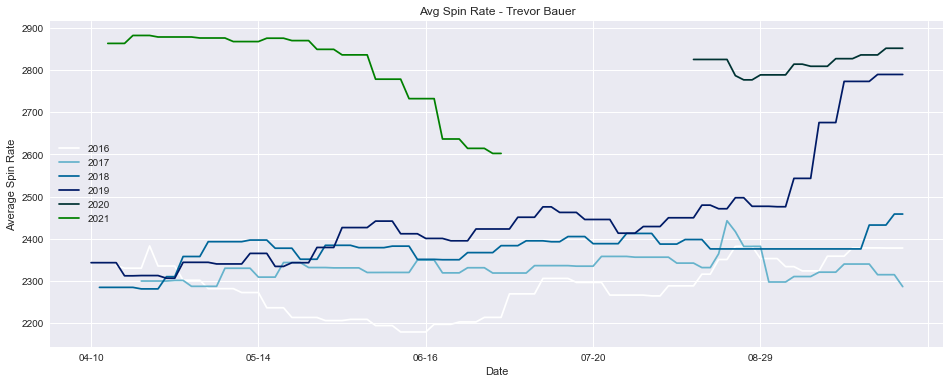

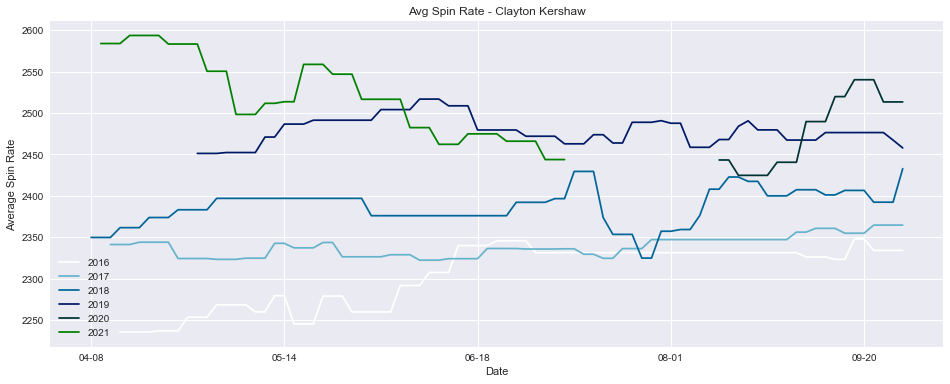

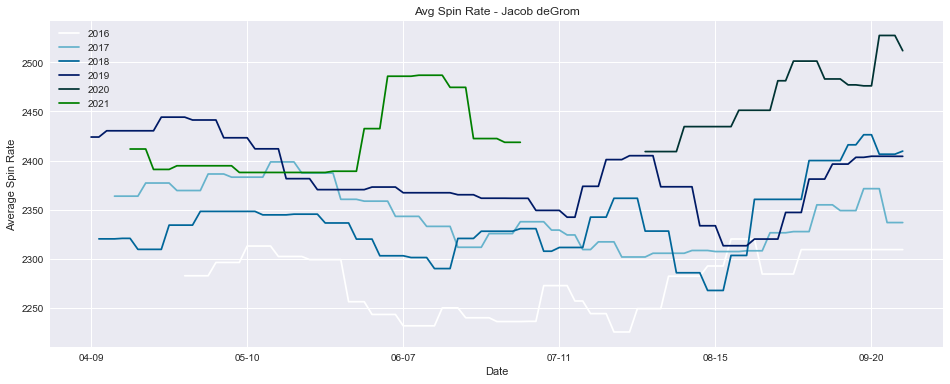

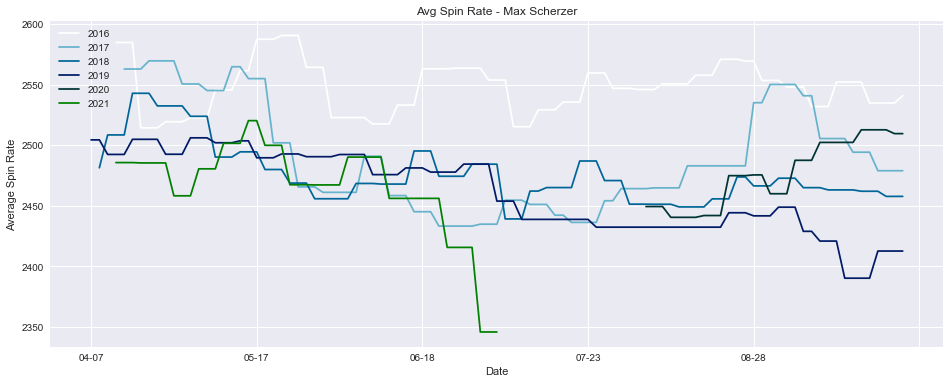

In [193]:
players = ['Cole, Gerrit', 'Bauer, Trevor', 'Kershaw, Clayton', 'deGrom, Jacob', 'Scherzer, Max']
for name in players:
    ax = plot_yoy_rate(fast_balls, 3, name)
    ax.set_title(f'Avg Spin Rate - {name.split(", ")[1]} {name.split(", ")[0]}')


In [ ]:
## USe pitching_stats_range to show the ERA and how that has changed over time with spin rates